In [31]:
import re
import nltk
import pymorphy2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim

%matplotlib inline

# Чтение файла 
pandas.read_csv сразу не сработал, пришлось парсить файл вручную.


Выводим первые 10 строк получившейся таблицы.

In [32]:
lines = []
with open("Данные для задания.csv", "r", encoding="UTF-8") as read_file:
    next(read_file)
    lines += [line.lstrip("\"") for line in read_file]
df = [l.split(",")[:5] + [" ".join(l.split(",")[5:])] for l in lines]
df = pd.DataFrame(df, columns=["url", "author", "type", "parent_post_url", "tag", "body"])
df.head(n=10)

,url,author,type,parent_post_url,tag,body
0,https://vk.com/wall505680146_2821,id505680146,Социальные сети,https://vk.com/wall-165936830_65882,0,"""""#show_must_go_on@wazzupbighit#bts#Jin#Suga#R..."
1,https://vk.com/wall-92124895_6308?reply=6329,id149164749,Социальные сети,https://vk.com/wall-92124895_6308,0,А может кто из Майкопа есть <fm>доброволец</fm...
2,https://vk.com/wall-7138849_2300?reply=2301,lyubars,Социальные сети,https://vk.com/wall-7138849_2300,0,"""""сказать сегодня трём людям правдивый комплим..."
3,https://vk.com/wall-146345852_579,afishadeti51,Социальные сети,https://vk.com/wall-114278140_9723,1,"""""Друзья! Репост<br>Большое социальное меропри..."
4,https://vk.com/wall509637155_124,id509637155,Социальные сети,https://vk.com/wall-137311321_2416,1,"""""ФИЛЬМ МИТРОПОЛИТА ИЛАРИОНА «СРЕТЕНИЕ»<br>Фил..."
5,https://vk.com/@bport-rss-1076887601-593977245,bport,Социальные сети,,1,"""""В<br>В Мурманске прошёл благотворительный сб..."
6,https://vk.com/wall-36397952_109659,useit_brain,Социальные сети,,0,"""""Важно! О деньгах.<br>1. Храните деньги в кру..."
7,https://vk.com/wall40881204_36781,id40881204,Социальные сети,https://vk.com/wall-124265034_5756,0,"""""Сегодня был очень насыщенный день!<br>Прошли..."
8,https://vk.com/wall-148666374_6811,amalia_avanesyan2012,Социальные сети,,1,"""""Друзья!♥ Время⏰ оно не ждёт😥 нам срочно надо..."
9,https://vk.com/wall-172077442_8840,obs2307,Социальные сети,,0,"""""Калужский заповедник зовет волонтеров<br>Зап..."


# Функции для "очистки" текста
- Удаление "мусора" из текста - регулярные выражения
- Для лемматизации используется библиотека [pymorphy2](https://pymorphy2.readthedocs.io/)
- Стоп-слова из библиотеки [nltk](https://www.nltk.org/)

In [33]:
# нерелевантный мусор
def clean(body):
    body = body.lower() # переводим в нижний регистр  
    body = re.sub(r"[^а-яА-Я ]", " ", body) # удаляем все кроме кириллицы
    body = " ".join([w for w in body.split() if len(w) > 1]) # удаляем однобуквенные слова
    body = re.sub(r'\s+', " ", body).strip() # удаляем лишние пробелы
    return body

# лемматизация
morph = pymorphy2.MorphAnalyzer()
def lemmatize(body): 
    body = " ".join([morph.parse(w)[0].normal_form for w in body.split()])
    return body

# стоп-слова
sw = ["это", "ещё", "весь", "свой", "который", "наш", "ваш"]
sw = list(set(stopwords.words("russian") + sw))
swpattern = re.compile(r'\b(' + r'|'.join(sw) + r')\b\s*')    
def deletesw(body):
    body = swpattern.sub(" ", body)
    body = re.sub(r'\s+', " ", body).strip() # удаляем лишние пробелы
    return body

# Пример обработки поста

### Исходный текст

In [34]:
example = df.iloc[3]['body']
example

'""Друзья! Репост<br>Большое социальное мероприятие - 4-я выставка собак из приютов """"Хочу домой!"""" состоится уже послезавтра! 17 февраля в Областной научной библиотеке на первом этаже. Фонд помощи животным """"Путеводная звезда""""<br>Показать полностью…  с с Центром развития волонтерского движения г.Мурманск организовали большую и интересную программу фудкорт  бесплатная консультация ветеринарного врача и дефиле собак из приюта  конкурсы и мастер-классы  показательные выступления пушистых артистов клуба """"Романов на Мурмане""""  зоо-эстафета  благотворительный аукцион!<br>Приходите сами  приглашайте своих родных и друзей! В празднике примут участие подопечные североморского приюта """"Надежда"""" и фонда помощи животным """"Путеводная звезда"""". Можно подарить понравившейся  собачке дом или поддержать сухим или влажным кормом. Узнать больше о выставке можно в группе мероприятия. <br>Встречаемся на Софьи Перовской 21А<br>с 14:00 до 16:30<br>Делай добро! Поддерживай животных! По

### Переводим в нижний регистр и убираем мусор 
 - специальные символы
 - латинские символы
 - лишние пробелы
 - однобуквенные слова
 - цифры

In [35]:
example = clean(example)
example

'друзья репост большое социальное мероприятие выставка собак из приютов хочу домой состоится уже послезавтра февраля областной научной библиотеке на первом этаже фонд помощи животным путеводная звезда показать полностью центром развития волонтерского движения мурманск организовали большую интересную программу фудкорт бесплатная консультация ветеринарного врача дефиле собак из приюта конкурсы мастер классы показательные выступления пушистых артистов клуба романов на мурмане зоо эстафета благотворительный аукцион приходите сами приглашайте своих родных друзей празднике примут участие подопечные североморского приюта надежда фонда помощи животным путеводная звезда можно подарить понравившейся собачке дом или поддержать сухим или влажным кормом узнать больше выставке можно группе мероприятия встречаемся на софьи перовской до делай добро поддерживай животных помогай подрастающему поколению северян стать ответственнее исебеилюдям хочудомой мурманск'

### Приводим слова к нормальной форме
Используется библиотека [pymorphy2](https://pymorphy2.readthedocs.io/)

In [36]:
example = lemmatize(example)
example

'друг репост большой социальный мероприятие выставка собака из приют хотеть домой состояться уже послезавтра февраль областной научный библиотека на первое этаж фонд помощь животный путеводный звезда показать полностью центр развитие волонтёрский движение мурманск организовать большой интересный программа фудкорт бесплатный консультация ветеринарный врач дефиле собака из приют конкурс мастер класс показательный выступление пушистый артист клуб роман на мурман зоо эстафета благотворительный аукцион приходить сам приглашать свой родные друг праздник принять участие подопечный североморский приют надежда фонд помощь животный путеводный звезда можно подарить понравиться собачка дом или поддержать сухой или влажный корм узнать большой выставка можно группа мероприятие встречаться на софья перовский до делать добро поддерживать животное помогать подрастать поколение северянин стать ответственный исебеичеловек хочудомой мурманск'

### Удаляем стоп слова

In [37]:
example = deletesw(example)
example

'друг репост большой социальный мероприятие выставка собака приют хотеть домой состояться послезавтра февраль областной научный библиотека первое этаж фонд помощь животный путеводный звезда показать полностью центр развитие волонтёрский движение мурманск организовать большой интересный программа фудкорт бесплатный консультация ветеринарный врач дефиле собака приют конкурс мастер класс показательный выступление пушистый артист клуб роман мурман зоо эстафета благотворительный аукцион приходить приглашать родные друг праздник принять участие подопечный североморский приют надежда фонд помощь животный путеводный звезда подарить понравиться собачка дом поддержать сухой влажный корм узнать большой выставка группа мероприятие встречаться софья перовский делать добро поддерживать животное помогать подрастать поколение северянин стать ответственный исебеичеловек хочудомой мурманск'

# Обработка всех постов

In [38]:
df["body_1"] = df.apply(lambda row: clean(row.body), axis=1) # мусор
df["body_2"] = df.apply(lambda row: lemmatize(row.body_1), axis=1) # лемматизация
df["body_3"] = df.apply(lambda row: deletesw(row.body_2), axis=1) # стоп-слова

# Считаем слова

И выводим 20 наиболее часто встречающихся

In [39]:
fdist = nltk.FreqDist()

for index, row in df.iterrows():
    for w in row["body_3"].split():
        fdist[w] += 1
        
top100 = fdist.most_common(100)
df2 = pd.DataFrame(top100, columns = ['word', 'count'])
df2.head(20)
#df2 # показать все 100

,word,count
0,год,1317
1,человек,1235
2,день,1005
3,благотворительный,844
4,мочь,785
5,помощь,696
6,ребёнок,692
7,жизнь,657
8,время,618
9,показать,525


# Строим график

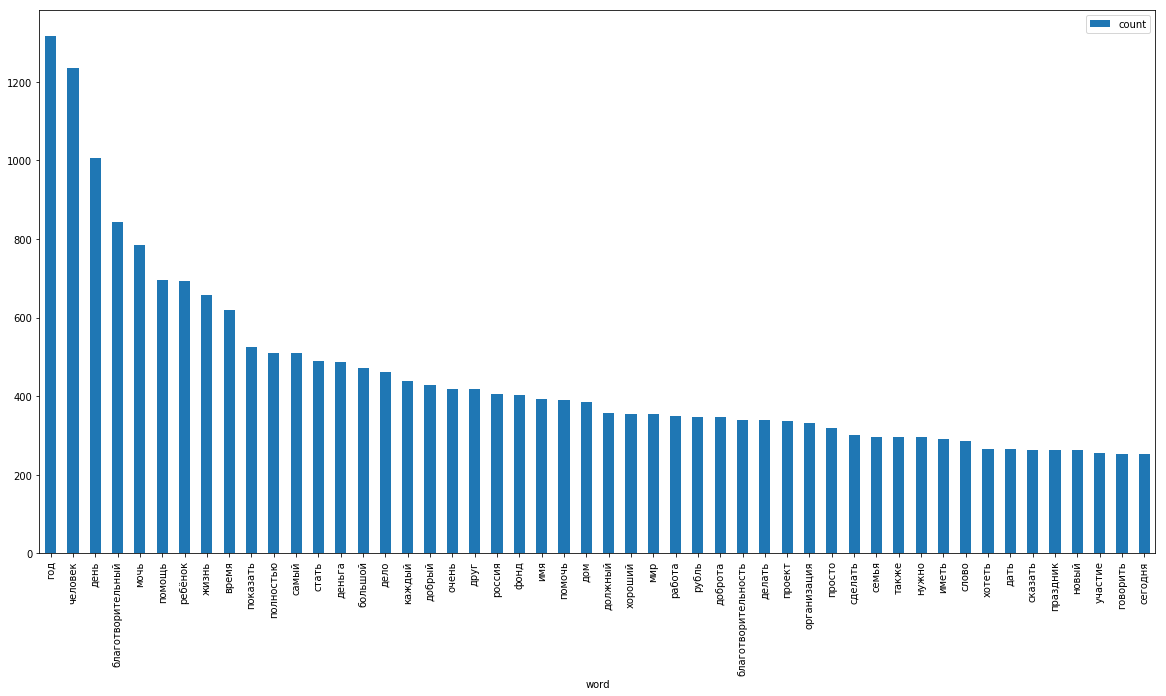

In [40]:
df2[:50].plot.bar(x='word', y='count', figsize=(20,10))

# Наблюдение
[pymorphy2](https://pymorphy2.readthedocs.io/) считает, что нормальная форма слова "**деньги**" это "**деньга**"

In [41]:
morph.parse("денег")

[Parse(word='денег', tag=OpencorporaTag('NOUN,inan,femn plur,gent'), normal_form='деньга', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'денег', 1268, 8),))]

In [42]:
morph.parse("деньги")

[Parse(word='деньги', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='деньга', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'деньги', 1268, 1),)),
 Parse(word='деньги', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='деньга', score=0.25, methods_stack=((<DictionaryAnalyzer>, 'деньги', 1268, 7),)),
 Parse(word='деньги', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='деньга', score=0.25, methods_stack=((<DictionaryAnalyzer>, 'деньги', 1268, 10),))]

# Устойчивые фразы

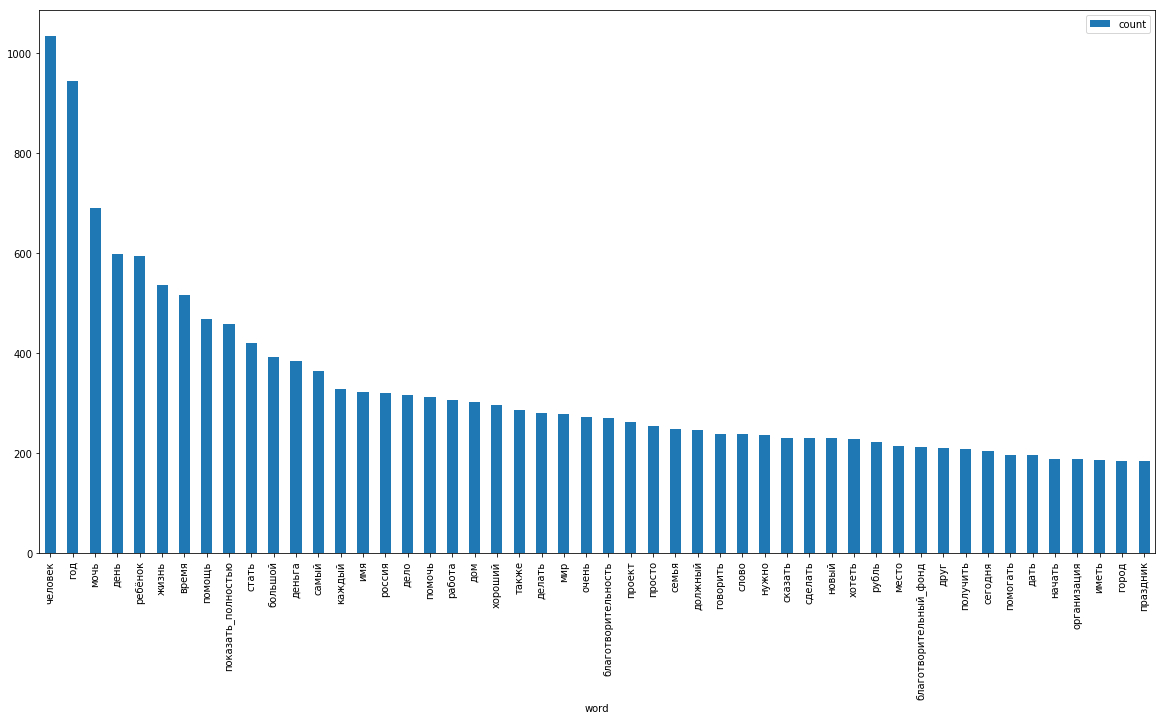

In [43]:
data = df.body_3.values.tolist()
data_words = [s.split() for s in data]

phrases = gensim.models.Phrases(data_words, min_count=3, threshold=10)
bigram = gensim.models.phrases.Phraser(phrases)

df["body_4"] = [" ".join(s) for s in bigram[data_words]]

fdist = nltk.FreqDist()

for index, row in df.iterrows():
    for w in row["body_4"].split():
        fdist[w] += 1
        
top100 = fdist.most_common(100)
df2 = pd.DataFrame(top100, columns = ['word', 'count'])
df2[:50].plot.bar(x='word', y='count', figsize=(20,10))